Set up, imports and Load Data

In [ ]:
import os
import gc
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.ion()
sns.set(style='whitegrid')

# Scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFinder
from sklearn.svm import OneClassSVM
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import catboost as cb
import xgboost as xgb

# Persistence
import joblib

# Imbalanced data
from imblearn.over_sampling import SMOTE

# Prompt user for base project path
BASE = Path(input("Enter the base project path: "))

# Create required directories if they don't exist
(BASE / 'data').mkdir(parents=True, exist_ok=True)
(BASE / 'models').mkdir(parents=True, exist_ok=True)
(BASE / 'oof').mkdir(parents=True, exist_ok=True)
(BASE / 'outputs').mkdir(parents=True, exist_ok=True)

SEED = 42
np.random.seed(SEED)

file_path = BASE / 'data' / 'transaction_dataset.csv'
df = pd.read_csv(file_path)
print('Loaded:', df.shape)
print(df.columns[:40])


Data Cleaning + EDA


Target distribution:
FLAG
0    0.778579
1    0.221421
Name: proportion, dtype: float64


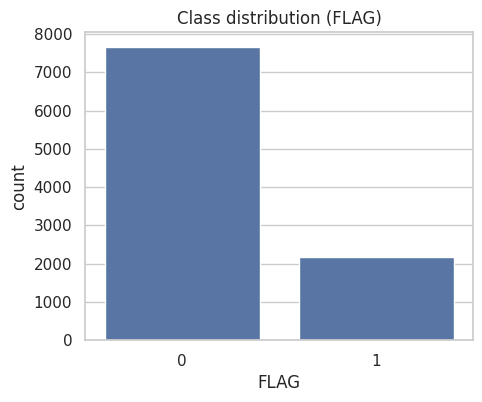

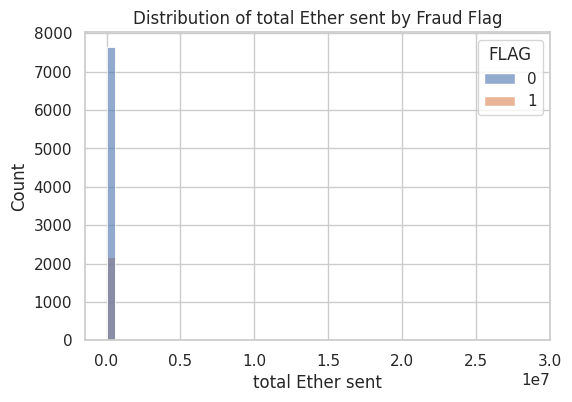

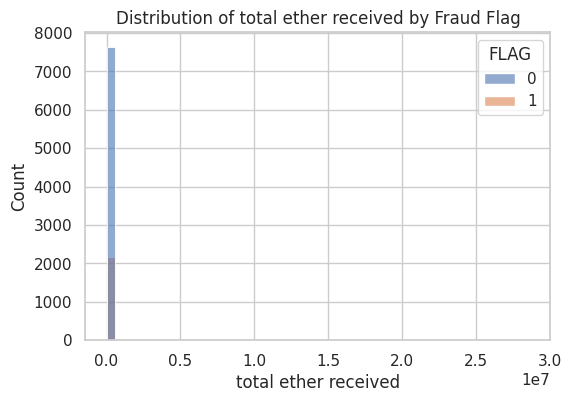

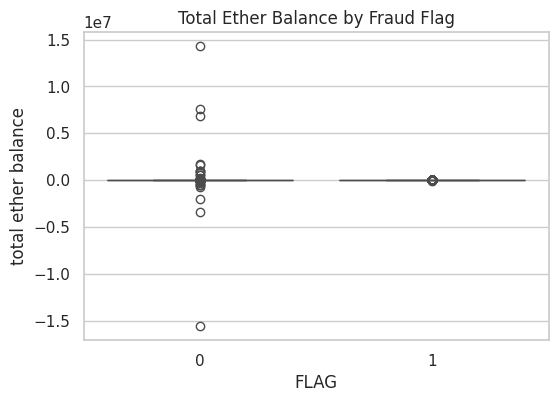

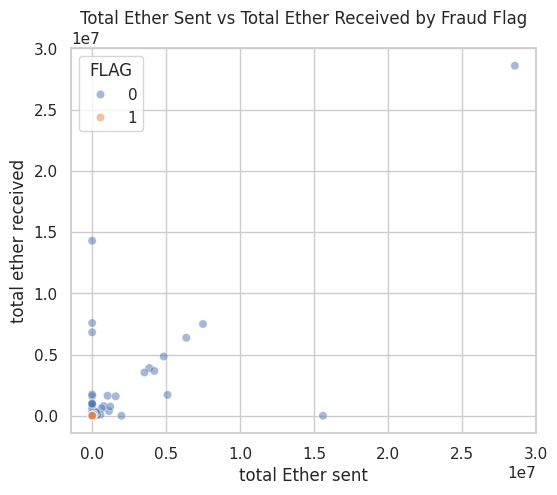

In [ ]:
# Quick target check
print('\nTarget distribution:')
print(df['FLAG'].value_counts(normalize=True))

# Countplot of target
plt.figure(figsize=(5,4))
sns.countplot(x='FLAG', data=df)
plt.title('Class distribution (FLAG)')
plt.show()

# Histograms: total_Ether_sent / total_ether_received
for col in ['total Ether sent', 'total ether received']:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, hue='FLAG', bins=50, alpha=0.6)
    plt.title(f'Distribution of {col} by Fraud Flag')
    plt.show()

# Boxplot: total_ether_balance
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='FLAG', y='total ether balance')
plt.title('Total Ether Balance by Fraud Flag')
plt.show()

# Scatterplot: total_ether_sent vs total_ether_received
plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x='total Ether sent', y='total ether received', hue='FLAG', alpha=0.5)
plt.title('Total Ether Sent vs Total Ether Received by Fraud Flag')
plt.show()

Feature engineering class

In [ ]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, cmap):
        self.c = cmap
    def fit(self, X, y=None):
        return self
    def _has(self, X, *cols):
        return all((col in X.columns) for col in cols if col is not None)
    def transform(self, X):
        X = X.copy()
        c = self.c
        try:
            if self._has(X, c['sent_tnx'], c['recv_tnx']):
                X['txn_direction_ratio'] = (X[c['sent_tnx']]+1) / (X[c['recv_tnx']]+1)
            if self._has(X, c['uniq_sent_to'], c['uniq_recv_from'], c['total_tx']):
                X['counterparty_density'] = (X[c['uniq_sent_to']]+X[c['uniq_recv_from']]) / (X[c['total_tx']]+1)
            if self._has(X, c['num_created_contracts']):
                X['has_contracts'] = (X[c['num_created_contracts']]>0).astype(int)

            if self._has(X, c['eth_recv'], c['eth_sent']):
                X['value_in_out_ratio'] = (X[c['eth_recv']]+1) / (X[c['eth_sent']]+1)
                if self._has(X, c['recv_tnx']):
                    X['avg_in_value_per_tx'] = X[c['eth_recv']] / (X[c['recv_tnx']]+1)
                if self._has(X, c['sent_tnx']):
                    X['avg_out_value_per_tx'] = X[c['eth_sent']] / (X[c['sent_tnx']]+1)
            if self._has(X, c['erc20_eth_recv'], c['erc20_eth_sent']):
                X['erc20_value_in_out_ratio'] = (X[c['erc20_eth_recv']]+1) / (X[c['erc20_eth_sent']]+1)

            if self._has(X, c['total_tx'], c['time_diff']):
                X['activity_rate'] = X[c['total_tx']] / (X[c['time_diff']]+1)
            if self._has(X, c['erc20_total_txs'], c['erc20_avg_time_sent'], c['erc20_avg_time_recv']):
                X['erc20_activity_rate'] = X[c['erc20_total_txs']] / (
                    X[c['erc20_avg_time_sent']] + X[c['erc20_avg_time_recv']] + 1
                )

            if self._has(X, c['erc20_uniq_sent_token'], c['erc20_uniq_recv_token']):
                X['erc20_token_diversity'] = X[c['erc20_uniq_sent_token']] + X[c['erc20_uniq_recv_token']]
            if self._has(X, c['erc20_uniq_sent_addr'], c['erc20_uniq_recv_addr'], c['erc20_uniq_recv_contract_addr']):
                X['erc20_address_diversity'] = (
                    X[c['erc20_uniq_sent_addr']] + X[c['erc20_uniq_recv_addr']] + X[c['erc20_uniq_recv_contract_addr']]
                )
        except Exception as e:
            print('FeatureEngineer warning:', e)
        return X

# mapping - adjust names to cleaned columns
c = {
    'flag': 'FLAG',
    'time_diff': 'Time_Diff_between_first_and_last_Mins',
    'sent_tnx': 'Sent_tnx',
    'recv_tnx': 'Received_Tnx',
    'uniq_sent_to': 'Unique_Sent_To_Addresses',
    'uniq_recv_from': 'Unique_Received_From_Addresses',
    'num_created_contracts': 'Number_of_Created_Contracts',
    'total_tx': 'total_transactions_including_tnx_to_create_contract',
    'eth_sent': 'total_Ether_sent',
    'eth_recv': 'total_ether_received',
    'eth_bal': 'total_ether_balance',
    'erc20_total_txs': 'Total_ERC20_tnxs',
    'erc20_eth_recv': 'ERC20_total_Ether_received',
    'erc20_eth_sent': 'ERC20_total_ether_sent',
    'erc20_avg_time_sent': 'ERC20_avg_time_between_sent_tnx',
    'erc20_avg_time_recv': 'ERC20_avg_time_between_rec_tnx',
    'erc20_uniq_sent_token': 'ERC20_uniq_sent_token_name',
    'erc20_uniq_recv_token': 'ERC20_uniq_rec_token_name',
    'erc20_uniq_sent_addr': 'ERC20_uniq_sent_addr',
    'erc20_uniq_recv_addr': 'ERC20_uniq_rec_addr',
    'erc20_uniq_recv_contract_addr': 'ERC20_uniq_rec_contract_addr',
    'cat_sent_type': 'ERC20_most_sent_token_type',
    'cat_recv_type': 'ERC20_most_rec_token_type'
}

Leakage checks & drop suspicious columns

In [ ]:
# Build X_full and y_full (drop ID columns)
id_cols = [nm for nm in ['Unnamed: 0', 'Index', 'Address'] if nm in df.columns]
print("ID cols detected:", id_cols)

# drop ID columns but keep everything else for checks
X_full = df.drop(columns=id_cols + ['FLAG'], errors='ignore')
y_full = df['FLAG'].astype(int)

print('Initial shapes — X_full:', X_full.shape, 'y_full:', y_full.shape)

# ----- 1) perfect/near-perfect correlation check -----
print("\n=== PERFECT / NEAR-PERFECT CORRELATION CHECK ===")
corrs = []
for col in X_full.columns:
    try:
        if pd.api.types.is_numeric_dtype(X_full[col]):
            corr_val = np.corrcoef(X_full[col].fillna(0).astype(float), y_full)[0,1]
            if abs(corr_val) > 0.95:
                corrs.append((col, float(corr_val)))
    except Exception:
        pass

print("High-corr cols:", corrs)

# ----- 2) unique-range check (numeric only) -----
print("\n=== UNIQUE VALUE RANGE CHECK (NUMERIC ONLY) ===")
suspicious_cols = []
numeric_cols = X_full.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    try:
        min_f, max_f = X_full.loc[y_full==1, col].min(), X_full.loc[y_full==1, col].max()
        min_nf, max_nf = X_full.loc[y_full==0, col].min(), X_full.loc[y_full==0, col].max()
        if pd.notna(min_f) and pd.notna(min_nf):
            if (min_f > max_nf) or (max_f < min_nf):
                suspicious_cols.append((col, (min_f, max_f), (min_nf, max_nf)))
    except Exception:
        pass
print("Non-overlapping numeric ranges:", suspicious_cols)

# ----- 3) mutual information check (numeric only) -----
print("\n=== MUTUAL INFORMATION CHECK (NUMERIC ONLY) ===")
from sklearn.feature_selection import mutual_info_classif
if len(numeric_cols) > 0:
    X_numeric = X_full[numeric_cols].fillna(0)
    try:
        mi = mutual_info_classif(X_numeric, y_full, random_state=SEED)
        mi_series = pd.Series(mi, index=numeric_cols).sort_values(ascending=False)
        print(mi_series.head(20))
    except Exception as e:
        print("MI computation failed:", e)
else:
    print("No numeric columns for MI.")

# ----- 4) fraud-only or normal-only values -----
print("\n=== FRAUD-ONLY OR NORMAL-ONLY FEATURE VALUES ===")
rare_flag_cols = []
for col in X_full.columns:
    try:
        u1 = X_full.loc[y_full==1, col].nunique()
        u0 = X_full.loc[y_full==0, col].nunique()
        if u1 == 1 or u0 == 1:
            rare_flag_cols.append((col, u1, u0))
    except Exception:
        pass
print("Constant for one class:", rare_flag_cols)

# Compose list to drop
cols_to_drop = set([c for c,_ in corrs] +
                    [c for (c,_,_) in suspicious_cols] +
                    [c for (c,_,_) in rare_flag_cols] +
                    id_cols)

print("\nDropping these suspicious cols (IDs + leaks):", cols_to_drop)

# Drop them from dataframe
X_clean = X_full.drop(columns=list(cols_to_drop), errors='ignore')
print("After drop X_clean shape:", X_clean.shape)

ID cols detected: ['Unnamed: 0', 'Index', 'Address']
Initial shapes — X_full: (9841, 47) y_full: (9841,)

=== PERFECT / NEAR-PERFECT CORRELATION CHECK ===
High-corr cols: []

=== UNIQUE VALUE RANGE CHECK (NUMERIC ONLY) ===
Non-overlapping numeric ranges: []

=== MUTUAL INFORMATION CHECK (NUMERIC ONLY) ===
Time Diff between first and last (Mins)                 0.237612
total ether balance                                     0.184990
max value received                                      0.183580
avg val received                                        0.177787
total ether received                                    0.165375
 ERC20 avg val rec                                      0.145535
 ERC20 min val rec                                      0.141012
total transactions (including tnx to create contract    0.124143
Unique Received From Addresses                          0.122189
Received Tnx                                            0.116635
Avg min between received tnx               

Train/Val/Test split (70/15/15)

In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X_clean, y_full, test_size=0.30, stratify=y_full, random_state=SEED
)
X_val, X_te, y_val, y_te = train_test_split(
    X_tmp, y_tmp, test_size=0.50, stratify=y_tmp, random_state=SEED
)
print('Splits:', X_tr.shape, X_val.shape, X_te.shape)


Splits: (6888, 36) (1476, 36) (1477, 36)


Preprocessing pipeline

In [ ]:
import re
def _norm(s):
    return re.sub(r'[^a-z0-9]', '', s.lower())

# determine categorical columns from mapping if present
categorical_cols = [nm for nm in [c['cat_sent_type'], c['cat_recv_type']] if nm in X_tr.columns]
numeric_cols = X_tr.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in id_cols + [c['flag']]]

count_keys = ['tnx','tx','uniq','numberofcreatedcontracts','addr','addresses']
count_like_cols = [col for col in numeric_cols if any(k in _norm(col) for k in count_keys) and col not in categorical_cols]
continuous_cols_raw = [col for col in numeric_cols if col not in categorical_cols and col not in count_like_cols]

# Log1pSelectedRaw
class Log1pSelectedRaw(BaseEstimator, TransformerMixin):
    def __init__(self, skew_threshold=1.0):
        self.skew_threshold = skew_threshold
        self.selected_cols_ = []
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        skewness = X[numeric_cols].apply(lambda x: x.skew()).fillna(0)
        self.selected_cols_ = skewness[skewness > self.skew_threshold].index.tolist()
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in self.selected_cols_:
            if col in X.columns:
                X[col] = np.log1p(np.clip(X[col].fillna(0).astype(float), a_min=0, a_max=None))
        return X

# Winsorizer
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower; self.upper = upper; self.bounds = {}
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            try:
                self.bounds[col] = (X[col].quantile(self.lower), X[col].quantile(self.upper))
            except Exception:
                self.bounds[col] = (None, None)
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col, (lo, hi) in self.bounds.items():
            if lo is not None and hi is not None and col in X.columns:
                X[col] = X[col].clip(lo, hi)
        return X

# Missing indicator adder
class MissingIndicatorAdder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold; self.cols = []
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        na = X.isna().mean()
        self.cols = na[na > self.threshold].index.tolist()
        return self
    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in self.cols:
            X[f"{col}__isna"] = X[col].isna().astype(int)
        return X

# ColumnTransformer pipelines
count_pipe = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value=0))])
cont_pipe  = Pipeline([('impute', SimpleImputer(strategy='median'))])
cat_pipe   = Pipeline([('impute', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

continuous_cols = continuous_cols_raw[:]  # will extend if needed

col_tf = ColumnTransformer(
    transformers=[
        ('count', count_pipe, count_like_cols),
        ('cont', cont_pipe, continuous_cols),
        ('cat', cat_pipe, categorical_cols)
    ],
    remainder='drop'
)

preprocessor = Pipeline(steps=[
    ('feat_eng', FeatureEngineer(c)),
    ('log1p', Log1pSelectedRaw(skew_threshold=1.0)),
    ('missing_flags', MissingIndicatorAdder(0.05)),
    ('by_type', col_tf),
    ('winsor', Winsorizer()),
    ('scale', RobustScaler())
])

# Fit transform
Xtr_p = preprocessor.fit_transform(X_tr)
Xva_p = preprocessor.transform(X_val)
Xte_p = preprocessor.transform(X_te)

print('Shapes — train/val/test:', getattr(Xtr_p, 'shape', None), getattr(Xva_p, 'shape', None), getattr(Xte_p, 'shape', None))

# Convert to numpy arrays
Xtr_p = np.asarray(Xtr_p)
Xva_p = np.asarray(Xva_p)
Xte_p = np.asarray(Xte_p)


Shapes — train/val/test: (6888, 34) (1476, 34) (1477, 34)


Augmentation (SMOTE) & class weights

In [ ]:
print('Before augmentation:', np.bincount(y_tr))
smote = SMOTE(random_state=42)
Xtr_bal, ytr_bal = smote.fit_resample(Xtr_p, y_tr.reset_index(drop=True))
print('After augmentation:', np.bincount(ytr_bal))

classes = np.unique(ytr_bal)
class_wts = compute_class_weight(class_weight='balanced', classes=classes, y=ytr_bal)
CLASS_WEIGHT = {int(c_): float(w) for c_, w in zip(classes, class_wts)}
print('Class weights:', CLASS_WEIGHT)

# Save preprocessor
joblib.dump(preprocessor, BASE / 'models' / 'preprocessor.joblib')

Before augmentation: [5363 1525]
After augmentation: [5363 5363]
Class weights: {0: 1.0, 1: 1.0}


['/content/drive/MyDrive/BT4012_project/models/preprocessor.joblib']

Multiple anomaly detectors OOF

In [ ]:
anomaly_detectors = {
    'iforest': IsolationForest(n_estimators=200, contamination=0.02, random_state=SEED),
    'elliptic': EllipticEnvelope(contamination=0.02, random_state=SEED),
    'lof': LocalOutlierFactor(n_neighbors=20, contamination=0.02, novelty=True),
    'ocsvm': OneClassSVM(nu=0.02, gamma='scale')
}

kf_oof = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# store oof scores in dict of arrays (shape: n_train)
anom_oofs = {k: np.zeros(Xtr_p.shape[0]) for k in anomaly_detectors.keys()}

for name, detector in anomaly_detectors.items():
    for fold, (tr_idx, val_idx) in enumerate(kf_oof.split(Xtr_p, y_tr)):
        # clone a fresh instance per fold
        det = pickle.loads(pickle.dumps(detector))
        try:
            # LocalOutlierFactor cannot be fit_predict with novelty=False on new data, but we set novelty=True above
            det.fit(Xtr_p[tr_idx])
            if hasattr(det, 'decision_function'):
                scores = -det.decision_function(Xtr_p[val_idx])  # higher = more anomalous
            elif hasattr(det, 'score_samples'):
                scores = -det.score_samples(Xtr_p[val_idx])
            else:
                # fallback to predict: outlier -> -1, normal -> 1
                preds = det.predict(Xtr_p[val_idx])
                scores = (preds == -1).astype(float)
            anom_oofs[name][val_idx] = scores
        except Exception as e:
            print(f'Anomaly {name} fold {fold} failed:', e)

# Fit full detectors and score val/test
anom_val = {}
anom_test = {}
for name, detector in anomaly_detectors.items():
    det = pickle.loads(pickle.dumps(detector))
    try:
        det.fit(Xtr_p)
        if hasattr(det, 'decision_function'):
            anom_val[name] = -det.decision_function(Xva_p)
            anom_test[name] = -det.decision_function(Xte_p)
        elif hasattr(det, 'score_samples'):
            anom_val[name] = -det.score_samples(Xva_p)
            anom_test[name] = -det.score_samples(Xte_p)
        else:
            anom_val[name] = (det.predict(Xva_p) == -1).astype(float)
            anom_test[name] = (det.predict(Xte_p) == -1).astype(float)
    except Exception as e:
        print(f'Anomaly {name} full fit/score failed:', e)

# Save OOFs
for name, arr in anom_oofs.items():
    pd.DataFrame({'index': X_tr.index, f'anomaly_oof_{name}': arr}).to_csv(BASE / 'oof' / f'anomaly_oof_{name}.csv', index=False)

# Basic comparison: which anomaly detector separates labels best on train OOF
for name, arr in anom_oofs.items():
    try:
        print(name, 'train OOF ROC AUC:', roc_auc_score(y_tr, arr))
    except Exception as e:
        print('Could not evaluate', name, e)

joblib.dump(anom_oofs, BASE / 'models' / 'anomaly_oofs_initial.pkl')


iforest train OOF ROC AUC: 0.48763580452584954
elliptic train OOF ROC AUC: 0.4867070363724732
lof train OOF ROC AUC: 0.478618830297454
ocsvm train OOF ROC AUC: 0.5855438141730069


['/content/drive/MyDrive/BT4012_project/models/anomaly_oofs_initial.pkl']

Pick best anomaly (simple heuristic) and append

In [ ]:
# Choose the anomaly detector with highest ROC AUC on training OOFs
best_name = None
best_score = -np.inf
for name, arr in anom_oofs.items():
    try:
        s = roc_auc_score(y_tr, arr)
        if s > best_score:
            best_score = s; best_name = name
    except Exception:
        continue
print('Best anomaly detector by train OOF ROC:', best_name, best_score)

# Append chosen anomaly as last column to datasets
if best_name is None:
    # fallback to isolation forest
    best_name = 'iforest'

iso_oof_scores = anom_oofs[best_name]
iso_val_scores = anom_val.get(best_name, np.zeros(Xva_p.shape[0]))
iso_test_scores = anom_test.get(best_name, np.zeros(Xte_p.shape[0]))

Xtr_p_anom = np.hstack([Xtr_p, iso_oof_scores.reshape(-1,1)])
Xva_p_anom = np.hstack([Xva_p, iso_val_scores.reshape(-1,1)])
Xte_p_anom = np.hstack([Xte_p, iso_test_scores.reshape(-1,1)])

# Save anomaly-arrays for reproducibility
np.save(BASE / 'data' / 'Xtr_p.npy', Xtr_p)
np.save(BASE / 'data' / 'Xtr_p_anom.npy', Xtr_p_anom)

Best anomaly detector by train OOF ROC: ocsvm 0.5855438141730069


Utility metrics function

In [ ]:
from sklearn.metrics import precision_recall_curve

def precision_at_k(y_true, y_score, k=0.1):
    # k fraction -> top k fraction by score
    n = len(y_score)
    top_k = int(np.ceil(k * n))
    idx = np.argsort(y_score)[-top_k:]
    return precision_score(y_true[idx], (y_score[idx] >= 0.5).astype(int))

Baseline models (LR, DT, RF) OOF (without anomaly)

In [ ]:
NFOLDS = 5
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

from sklearn.base import clone

def get_oof_sklearn(model, X, y, kf):
    oof = np.zeros(X.shape[0])
    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
        m = clone(model)
        try:
            m.set_params(random_state=SEED)
        except Exception:
            pass
        m.fit(X[tr_idx], y.iloc[tr_idx])
        if hasattr(m, 'predict_proba'):
            oof[val_idx] = m.predict_proba(X[val_idx])[:,1]
        else:
            oof[val_idx] = m.predict(X[val_idx])
    return oof

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight=CLASS_WEIGHT)
oof_lr = get_oof_sklearn(lr, Xtr_p, y_tr.reset_index(drop=True), kf)
pd.DataFrame({'y_true': y_tr.reset_index(drop=True), 'y_pred': oof_lr}).to_csv(BASE / 'oof' / 'oof_lr.csv', index=False)
joblib.dump(lr.fit(Xtr_p, y_tr.reset_index(drop=True)), BASE / 'models' / 'logistic.pkl')
print('LR ROC AUC:', roc_auc_score(y_tr, oof_lr))

# Decision Tree
dt = DecisionTreeClassifier(class_weight='balanced', random_state=SEED)
oof_dt = get_oof_sklearn(dt, Xtr_p, y_tr.reset_index(drop=True), kf)
pd.DataFrame({'y_true': y_tr.reset_index(drop=True), 'y_pred': oof_dt}).to_csv(BASE / 'oof' / 'oof_dt.csv', index=False)
joblib.dump(dt.fit(Xtr_p, y_tr.reset_index(drop=True)), BASE / 'models' / 'decision_tree.pkl')
print('DT ROC AUC:', roc_auc_score(y_tr, oof_dt))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, class_weight=CLASS_WEIGHT, n_jobs=-1, random_state=SEED)
oof_rf = get_oof_sklearn(rf, Xtr_p, y_tr.reset_index(drop=True), kf)
pd.DataFrame({'y_true': y_tr.reset_index(drop=True), 'y_pred': oof_rf}).to_csv(BASE / 'oof' / 'oof_rf.csv', index=False)
joblib.dump(rf.fit(Xtr_p, y_tr.reset_index(drop=True)), BASE / 'models' / 'random_forest.pkl')
print('RF ROC AUC:', roc_auc_score(y_tr, oof_rf))

print('Saved baseline OOFs and models')

LR ROC AUC: 0.9592689435506797
DT ROC AUC: 0.9080649746441157
RF ROC AUC: 0.9881516034272474
Saved baseline OOFs and models


GBDT models (LightGBM, CatBoost & XGBoost) base + anomaly

In [ ]:
params = {'objective':'binary', 'metric':'auc', 'verbosity':-1, 'seed':SEED}

# LightGBM base
oof_lgb = np.zeros(len(y_tr))
for fold, (tr_idx, val_idx) in enumerate(kf.split(Xtr_p, y_tr)):
    dtrain = lgb.Dataset(Xtr_p[tr_idx], label=y_tr.reset_index(drop=True).iloc[tr_idx])
    dval = lgb.Dataset(Xtr_p[val_idx], label=y_tr.reset_index(drop=True).iloc[val_idx])
    model = lgb.train(params, dtrain, valid_sets=[dval], num_boost_round=500)
    oof_lgb[val_idx] = model.predict(Xtr_p[val_idx])
pd.DataFrame({'y_true': y_tr.reset_index(drop=True), 'y_pred': oof_lgb}).to_csv(BASE / 'oof' / 'oof_lgb_base.csv', index=False)
with open(BASE / 'models' / 'lgb_base.pkl', 'wb') as f:
    pickle.dump(model, f)
print('LightGBM base ROC:', roc_auc_score(y_tr, oof_lgb))

# LightGBM + anomaly
oof_lgb_anom = np.zeros(len(y_tr))
for fold, (tr_idx, val_idx) in enumerate(kf.split(Xtr_p_anom, y_tr)):
    dtrain = lgb.Dataset(Xtr_p_anom[tr_idx], label=y_tr.reset_index(drop=True).iloc[tr_idx])
    dval = lgb.Dataset(Xtr_p_anom[val_idx], label=y_tr.reset_index(drop=True).iloc[val_idx])
    model_an = lgb.train(params, dtrain, valid_sets=[dval], num_boost_round=500)
    oof_lgb_anom[val_idx] = model_an.predict(Xtr_p_anom[val_idx])
pd.DataFrame({'y_true': y_tr.reset_index(drop=True), 'y_pred': oof_lgb_anom}).to_csv(BASE / 'oof' / 'oof_lgb_anom.csv', index=False)
with open(BASE / 'models' / 'lgb_anom.pkl', 'wb') as f:
    pickle.dump(model_an, f)
print('LightGBM+anom ROC:', roc_auc_score(y_tr, oof_lgb_anom))

# CatBoost base
oof_cb = np.zeros(len(y_tr))
for fold, (tr_idx, val_idx) in enumerate(kf.split(Xtr_p, y_tr)):
    model_cb = cb.CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, random_seed=SEED, verbose=False)
    model_cb.fit(Xtr_p[tr_idx], y_tr.reset_index(drop=True).iloc[tr_idx], eval_set=(Xtr_p[val_idx], y_tr.reset_index(drop=True).iloc[val_idx]), early_stopping_rounds=50, verbose=False)
    oof_cb[val_idx] = model_cb.predict_proba(Xtr_p[val_idx])[:,1]
pd.DataFrame({'y_true': y_tr.reset_index(drop=True), 'y_pred': oof_cb}).to_csv(BASE / 'oof' / 'oof_cb_base.csv', index=False)
with open(BASE / 'models' / 'cb_base.pkl', 'wb') as f:
    pickle.dump(model_cb, f)
print('CatBoost base ROC:', roc_auc_score(y_tr, oof_cb))

# CatBoost + anomaly
oof_cb_anom = np.zeros(len(y_tr))
for fold, (tr_idx, val_idx) in enumerate(kf.split(Xtr_p_anom, y_tr)):
    model_cb_a = cb.CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, random_seed=SEED, verbose=False)
    model_cb_a.fit(Xtr_p_anom[tr_idx], y_tr.reset_index(drop=True).iloc[tr_idx], eval_set=(Xtr_p_anom[val_idx], y_tr.reset_index(drop=True).iloc[val_idx]), early_stopping_rounds=50, verbose=False)
    oof_cb_anom[val_idx] = model_cb_a.predict_proba(Xtr_p_anom[val_idx])[:,1]
pd.DataFrame({'y_true': y_tr.reset_index(drop=True), 'y_pred': oof_cb_anom}).to_csv(BASE / 'oof' / 'oof_cb_anom.csv', index=False)
with open(BASE / 'models' / 'cb_anom.pkl', 'wb') as f:
    pickle.dump(model_cb_a, f)
print('CatBoost+anom ROC:', roc_auc_score(y_tr, oof_cb_anom))

# XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': SEED
}

# XGBoost base
oof_xgb = np.zeros(len(y_tr))

for fold, (tr_idx, val_idx) in enumerate(kf.split(Xtr_p, y_tr)):
    dtrain = xgb.DMatrix(Xtr_p[tr_idx], label=y_tr.reset_index(drop=True).iloc[tr_idx])
    dval   = xgb.DMatrix(Xtr_p[val_idx], label=y_tr.reset_index(drop=True).iloc[val_idx])

    model_xgb = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=500,
        evals=[(dval, "valid")],
        verbose_eval=False
    )

    oof_xgb[val_idx] = model_xgb.predict(xgb.DMatrix(Xtr_p[val_idx]))

# save outputs
pd.DataFrame({'y_true': y_tr.reset_index(drop=True), 'y_pred': oof_xgb}).to_csv(
    BASE / 'oof' / 'oof_xgb_base.csv', index=False
)
with open(BASE / 'models' / 'xgb_base.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)

print("XGBoost base ROC:", roc_auc_score(y_tr, oof_xgb))

# XGBoost + anomaly
oof_xgb_anom = np.zeros(len(y_tr))

for fold, (tr_idx, val_idx) in enumerate(kf.split(Xtr_p_anom, y_tr)):
    dtrain = xgb.DMatrix(Xtr_p_anom[tr_idx], label=y_tr.reset_index(drop=True).iloc[tr_idx])
    dval   = xgb.DMatrix(Xtr_p_anom[val_idx], label=y_tr.reset_index(drop=True).iloc[val_idx])

    model_xgb_a = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=500,
        evals=[(dval, "valid")],
        verbose_eval=False
    )

    oof_xgb_anom[val_idx] = model_xgb_a.predict(xgb.DMatrix(Xtr_p_anom[val_idx]))

# save outputs
pd.DataFrame({'y_true': y_tr.reset_index(drop=True), 'y_pred': oof_xgb_anom}).to_csv(
    BASE / 'oof' / 'oof_xgb_anom.csv', index=False
)
with open(BASE / 'models' / 'xgb_anom.pkl', 'wb') as f:
    pickle.dump(model_xgb_a, f)

print("XGBoost+anom ROC:", roc_auc_score(y_tr, oof_xgb_anom))


LightGBM base ROC: 0.9897071311322572
LightGBM+anom ROC: 0.9898953668579185
CatBoost base ROC: 0.9903069299969738
CatBoost+anom ROC: 0.9899967292590703
XGBoost base ROC: 0.9904784146382469
XGBoost+anom ROC: 0.9904089648869148


MLP (sklearn) OOF

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(128,64), activation='relu', solver='adam', max_iter=500, random_state=SEED)
oof_mlp = get_oof_sklearn(mlp, Xtr_p, y_tr.reset_index(drop=True), kf)
pd.DataFrame({'y_true': y_tr.reset_index(drop=True), 'y_pred': oof_mlp}).to_csv(BASE / 'oof' / 'oof_mlp.csv', index=False)
mlp.fit(Xtr_p, y_tr.reset_index(drop=True))
joblib.dump(mlp, BASE / 'models' / 'mlp.pkl')
print('MLP ROC AUC:', roc_auc_score(y_tr, oof_mlp))

# MLP with anomaly column
mlp_an = MLPClassifier(hidden_layer_sizes=(128,64), activation='relu', solver='adam', max_iter=500, random_state=SEED)
oof_mlp_an = get_oof_sklearn(mlp_an, Xtr_p_anom, y_tr.reset_index(drop=True), kf)
pd.DataFrame({'y_true': y_tr.reset_index(drop=True), 'y_pred': oof_mlp_an}).to_csv(BASE / 'oof' / 'oof_mlp_anom.csv', index=False)
mlp_an.fit(Xtr_p_anom, y_tr.reset_index(drop=True))
joblib.dump(mlp_an, BASE / 'models' / 'mlp_anom.pkl')
print('MLP+anom ROC AUC:', roc_auc_score(y_tr, oof_mlp_an))


MLP ROC AUC: 0.9808181743152076
MLP+anom ROC AUC: 0.9789108738380463


Stacking using OOFs

In [ ]:
from sklearn.linear_model import LogisticRegression

# ---------------------------
# Stacking using OOFs (meta-learner)
# ---------------------------
# Load each OOF file
oof_lr_df        = pd.read_csv(BASE / 'oof' / 'oof_lr.csv')
oof_dt_df        = pd.read_csv(BASE / 'oof' / 'oof_dt.csv')
oof_rf_df        = pd.read_csv(BASE / 'oof' / 'oof_rf.csv')

oof_lgb_base_df  = pd.read_csv(BASE / 'oof' / 'oof_lgb_base.csv')
oof_lgb_anom_df  = pd.read_csv(BASE / 'oof' / 'oof_lgb_anom.csv')

oof_cb_base_df   = pd.read_csv(BASE / 'oof' / 'oof_cb_base.csv')
oof_cb_anom_df   = pd.read_csv(BASE / 'oof' / 'oof_cb_anom.csv')

oof_xgb_base_df  = pd.read_csv(BASE / 'oof' / 'oof_xgb_base.csv')
oof_xgb_anom_df  = pd.read_csv(BASE / 'oof' / 'oof_xgb_anom.csv')

oof_mlp_df       = pd.read_csv(BASE / 'oof' / 'oof_mlp.csv')
oof_mlp_anom_df  = pd.read_csv(BASE / 'oof' / 'oof_mlp_anom.csv')

# ---------------------------
# Sanity check alignment
# ---------------------------
assert oof_lr_df["y_true"].equals(oof_dt_df["y_true"])
assert oof_lr_df["y_true"].equals(oof_rf_df["y_true"])
# (Other asserts optional)

# ---------------------------
# Build the stacking dataframe
# ---------------------------
stack_df = pd.DataFrame({
    "y_true":        oof_lr_df["y_true"].values,

    "lr":            oof_lr_df["y_pred"].values,
    "dt":            oof_dt_df["y_pred"].values,
    "rf":            oof_rf_df["y_pred"].values,

    "lgb_base":      oof_lgb_base_df["y_pred"].values,
    "lgb_anom":      oof_lgb_anom_df["y_pred"].values,

    "cb_base":       oof_cb_base_df["y_pred"].values,
    "cb_anom":       oof_cb_anom_df["y_pred"].values,

    "xgb_base":      oof_xgb_base_df["y_pred"].values,
    "xgb_anom":      oof_xgb_anom_df["y_pred"].values,

    "mlp":           oof_mlp_df["y_pred"].values,
    "mlp_anom":      oof_mlp_anom_df["y_pred"].values,
})

meta_features = [
    "lr", "dt", "rf",
    "lgb_base", "lgb_anom",
    "cb_base", "cb_anom",
    "xgb_base", "xgb_anom",
    "mlp", "mlp_anom",
]

stack_X = stack_df[meta_features].values
stack_y = stack_df["y_true"].values

# ---------------------------
# Meta-learner: Logistic Regression
# ---------------------------
meta = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="lbfgs",
)

meta_oof = np.zeros(len(stack_y))

for fold, (tr_idx, val_idx) in enumerate(kf.split(stack_X, stack_y)):
    meta.fit(stack_X[tr_idx], stack_y[tr_idx])
    meta_oof[val_idx] = meta.predict_proba(stack_X[val_idx])[:, 1]

# Save meta OOF for plots
pd.DataFrame({"y_true": stack_y, "y_pred": meta_oof}).to_csv(
    BASE / "oof" / "oof_meta.csv",
    index=False,
)

# Save model + features for deployment
joblib.dump(meta,          BASE / "models" / "meta_model.pkl")
joblib.dump(meta_features, BASE / "models" / "meta_features.pkl")

print("Stacking ROC AUC:", roc_auc_score(stack_y, meta_oof))
print("Stacking PR  AUC:", average_precision_score(stack_y, meta_oof))

print("Stacking Precision@10%:",
      precision_at_k(stack_y, meta_oof, k=0.10))

Stacking ROC AUC: 0.9900968078179878
Stacking PR  AUC: 0.9755595900718941
Stacking Precision@10%: 0.9970972423802612


Final evaluation summary and save

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

def eval_model_oof(name, y_true, y_pred, k=0.10):
    return {
        "model": name,
        "roc_auc": float(roc_auc_score(y_true, y_pred)),
        "pr_auc": float(average_precision_score(y_true, y_pred)),
        f"precision@{int(k*100)}%": float(precision_at_k(y_true, y_pred, k=k)),
    }

results = []

results.append(eval_model_oof("LR",           y_tr.reset_index(drop=True), oof_lr))
results.append(eval_model_oof("DT",           y_tr.reset_index(drop=True), oof_dt))
results.append(eval_model_oof("RF",           y_tr.reset_index(drop=True), oof_rf))

# LightGBM
results.append(eval_model_oof("LGB_base",     y_tr.reset_index(drop=True), oof_lgb))
results.append(eval_model_oof("LGB_anom",     y_tr.reset_index(drop=True), oof_lgb_anom))

# CatBoost
results.append(eval_model_oof("CB_base",      y_tr.reset_index(drop=True), oof_cb))
results.append(eval_model_oof("CB_anom",      y_tr.reset_index(drop=True), oof_cb_anom))

# XGBoost (NEW)
results.append(eval_model_oof("XGB_base",     y_tr.reset_index(drop=True), oof_xgb))
results.append(eval_model_oof("XGB_anom",     y_tr.reset_index(drop=True), oof_xgb_anom))

# MLP
results.append(eval_model_oof("MLP",          y_tr.reset_index(drop=True), oof_mlp))
results.append(eval_model_oof("MLP_anom",     y_tr.reset_index(drop=True), oof_mlp_an))

# Meta-stacking layer
results.append(eval_model_oof("META_stack",   y_tr.reset_index(drop=True), meta_oof))

# Save summary
res_df = pd.DataFrame(results)
res_df.to_csv(BASE / "outputs" / "results_summary.csv", index=False)
print(res_df)

# Save preprocessor bundle
joblib.dump({"preprocessor": preprocessor}, BASE / "models" / "preprocessor_bundle.joblib")
print("All artifacts saved to", BASE)


         model   roc_auc    pr_auc  precision@10%
0           LR  0.959269  0.894571       0.956459
1           DT  0.908065  0.761935       0.873730
2           RF  0.988152  0.969827       0.997097
3     LGB_base  0.989707  0.978354       1.000000
4     LGB_anom  0.989895  0.977375       0.997097
5      CB_base  0.990307  0.976484       1.000000
6      CB_anom  0.989997  0.975858       1.000000
7     XGB_base  0.990478  0.977175       1.000000
8     XGB_anom  0.990409  0.976668       1.000000
9          MLP  0.980818  0.960169       0.992743
10    MLP_anom  0.978911  0.959335       1.000000
11  META_stack  0.990097  0.975560       0.997097
All artifacts saved to /content/drive/MyDrive/BT4012_project
